# Differential Equations III
# Outbreak Modeling in RStan

<img src="img/de3.png" style="height: 400px; width:auto;">

# Outline
- Compartmental ODEs
- The SIR Model
- The Boarding School Influenza Dataset
- Implementation

# Compartmental ODEs

Previously, we defined ordinary differential equations (ODEs), as equations or systems of equations that associate a function with one or more derivatives. They often involve finding a function whose derivative is defined in terms of the function itself.

Compartmental ODEs divide a population of something into states, and a good example is the SIR (susceptible, infectious, recovered) model of infectious disease modeling. Obviously, this is fairly simple; we could augment it to deal with hospitalizations, interventions, fatality, and so on.

# The SIR Model

The temporal dynamics of the SIR model are governed by the following system of equations.

$\frac{dS}{dt} = - \beta S \frac{I}{N}$

$\frac{dI}{dt} = \beta S \frac{I}{N} - \gamma I$

$\frac{dR}{dt} = \gamma I$

- $S$, $I$, and $R$ are shorthand for $S(t)$, $I(t)$, and $R(t)$, the susceptible, infectious, and recovered individuals at time $t$.

- $\beta$ is the constant rate of infectious contact between people.

- $\gamma$ is the constant rate of recovery of infected individuals.

- $\frac{I}{N}$ is the proportion of infected people among the population.

The major assumptions we are making include:

- Births and deaths do not contribute to the population dynamics
- Individuals are immune after infection.
- Constant infection and recovery rates.
- A homogenous population.
- Individuals meet uniformly and at random.

The probability of becoming infected if susceptible is $\beta \frac{I}{N}$. Therefore, at each time step, $\beta S \frac{I}{N}$ susceptible individuals become infected. The recovery of an infected individual takes place at rate $\gamma$, therefore the number of infected individuals decreases with speed $\gamma I$ and the number of recovered grows at the same number.

To observe an increase in the number of infectious hosts, the influx of new infections, given by $\beta SI$, must exceed the outflow due to recovery, $\gamma I$. The effective reproduction number $R$, not to be confused with the $R$ used for recovered individuals, can be calculated as $R = \frac{\beta S}{\gamma}$. This represents the average number of secondary infectious caused by one infectious individual. $R$ is not a rate, but a dimensionless number describing the total secondary cases. The recovery rate $\gamma$ is related to the average duration of infectiousness $D$ by $D = \frac{1}{\gamma}$. Therefore, $R$ can also be expressed as $R = D \beta S$. At the start of an outbreak, when the entire population is susceptible ($S = S_0$), the basic reproduction number $R_0$ is given by $R_0 = \frac{\beta S}{\gamma} = D \beta S$.

# The Boarding School Influenza Dataset

The <code>outbreaks</code> package of R includes a well-known dataset studying a 1978 influenza outbreak at a British boarding school. What's nice about this is that we know the total population of the boarding school (763), so we have a value for N. It also aligns fairly well with the assumptions being made by the model. As with the last article, we'll use Stan (specifically <code>rstan</code>) to make probabilistic predictions by placing priors over our parameters and using MCMC sampling for inference. The code is adapted from the <a href="https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#3_scaling_up_ode-based_models">paper</a> "Bayesian workflow for disease transmission modeling in Stan", found in the Stan user docs.

In [ ]:
# install.packages("BiocManager")
# library("BiocManager")
# install.packages("remotes")
# remotes::install_github("reconhub/outbreaks")
# BiocManager::install("rstan")
library(outbreaks)
library(rstan)
library(ggplot2)
library(tidyr)
library(dplyr)

We'll start by importing and visualizing the data.

In [30]:
nrow(influenza_england_1978_school)
head(influenza_england_1978_school)

[1] 14

,date,in_bed,convalescent
,<date>,<int>,<int>
1,1978-01-22,3,0
2,1978-01-23,8,0
3,1978-01-24,26,0
4,1978-01-25,76,0
5,1978-01-26,225,9
6,1978-01-27,298,17


And plotting it as a time series.

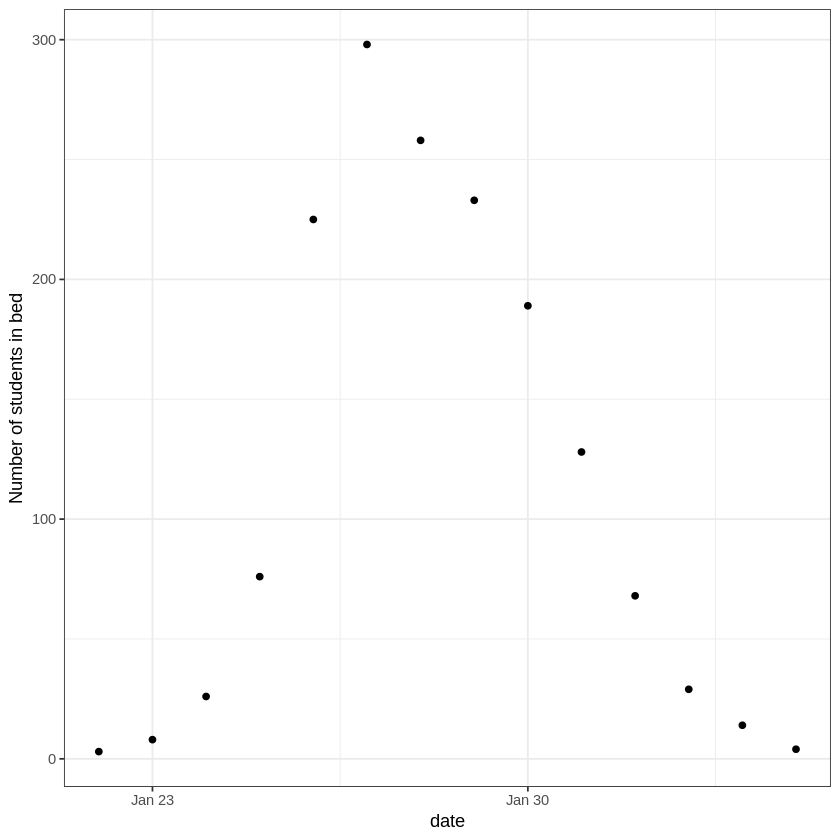

In [3]:
theme_set(theme_bw())
ggplot(data = influenza_england_1978_school) +
  geom_point(mapping = aes(x = date, y = in_bed)) +
  labs(y = "Number of students in bed")

# Implementation

To specify an ODE in Stan, we first code a function in the <code>functions{}</code> block, observing a strict signature:

<code>real[] f(real time, real[] state, real[] theta, real[] x_r, int[] x_i)</code>

- <code>time</code> represents the observed times at which measurements were made.
- <code>state</code>, which we'll label <code>z</code>, represents the populations of each species.
- <code>theta</code> represents the variables used to compute <code>f</code>, which depend on the model parameters
- <code>x_r</code> are real variables used to evaluate <code>f</code>, which only depend on fixed data
- <code>x_i</code> are integer values used to evaluate <code>f</code>, which only depend on fixed data

We then unpack the <code>y</code> variable into compartments, and the parameters <code>theta</code> into our <code>beta</code> and <code>gamma</code> values. The SIR equations are then applied, and the derivatives returned.

In [4]:
# functions {
#   real[] f(real t, real[] y, real[] theta,
#              real[] x_r, int[] x_i) {

#       real S = y[1];
#       real I = y[2];
#       real R = y[3];
#       real N = x_i[1];

#       real beta = theta[1];
#       real gamma = theta[2];

#       real dS_dt = -beta * I * S / N;
#       real dI_dt =  beta * I * S / N - gamma * I;
#       real dR_dt =  gamma * I;

#       return {dS_dt, dI_dt, dR_dt};
#   }
# }

In the <code>data{}</code> block, we define variables to be passed into the model, include the number of days <code>n_days</code>, the initial time (0) <code>t0</code>, the measured time points <code>ts</code>, the population size <code>N</code>, and the number of <code>cases</code> for each day.

In [ ]:
# data {
#   int<lower=1> n_days;
#   real y0[3];
#   real t0;
#   real ts[n_days];
#   int N;
#   int cases[n_days];
# }

Below we define the data items that will be a part of the data list.

In [10]:
# cases and population size
cases <- influenza_england_1978_school$in_bed
N <- 763;

# times
n_days <- length(cases)       # length of timeframe
t <- seq(0, n_days, by = 1)   # time points
t0 = 0                        # initial time point (0)
t <- t[-1]                    # removes first element from vector t

#initial conditions
i0 <- 1                           # initial number infectious (1)
s0 <- N - i0                      # initial number susceptible (pop - 1)
r0 <- 0                           # initial number recovered (0)
y0 = c(S = s0, I = i0, R = r0)    # compiling into list

The <code>transformed data{}</code> block is used to create and define data structures that may depend on input data but will not change during the sampling process. The <code>parameters{}</code> block is used to name parameters we will be using during the sampling process.

In [ ]:
# transformed data {
#   real x_r[0];
#   int x_i[1] = { N };
# }

# parameters {
#   real<lower=0> gamma;
#   real<lower=0> beta;
#   real<lower=0> phi_inv;
# }

The <code>transformed parameters{}</code> block houses the ODE solving function, and we'll again opt for the <code>rk45</code> method. The syntax is as follows:

<code>integrate_ode_rk45(system, y0, t0, ts, theta, x_r, x_i, rel_tol, abs_tol, max_num_steps)</code>

In [ ]:
# transformed parameters{
#   real y[n_days, 3];
#   real phi = 1. / phi_inv;
#   {
#     real theta[2];
#     theta[1] = beta;
#     theta[2] = gamma;

#     y = integrate_ode_rk45(f, y0, t0, ts, theta, x_r, x_i);
#   }
# }

In the <code>model{}</code> and <code>generated quantities{}</code> block, we set priors and model the noise as being negative binomially distributed.

In [ ]:
# model {
#   //priors
#   beta ~ normal(2, 1);
#   gamma ~ normal(0.4, 0.5);
#   phi_inv ~ exponential(5);

#   //likelihood
#   cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);
# }

# generated quantities {
#   real R0 = beta / gamma;
#   real recovery_time = 1 / gamma;
#   real pred_cases[n_days];
#   pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2) + 1e-5, phi);
# }

Putting it all together:

In [5]:
# adapted from https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#3_scaling_up_ode-based_models

stan_code <- "

functions {
  real[] f(real t, real[] y, real[] theta,
             real[] x_r, int[] x_i) {

      real S = y[1];
      real I = y[2];
      real R = y[3];
      real N = x_i[1];

      real beta = theta[1];
      real gamma = theta[2];

      real dS_dt = -beta * I * S / N;
      real dI_dt =  beta * I * S / N - gamma * I;
      real dR_dt =  gamma * I;

      return {dS_dt, dI_dt, dR_dt};
  }
}

data {
  int<lower=1> n_days;
  real y0[3];
  real t0;
  real ts[n_days];
  int N;
  int cases[n_days];
}

transformed data {
  real x_r[0];
  int x_i[1] = { N };
}

parameters {
  real<lower=0> gamma;
  real<lower=0> beta;
  real<lower=0> phi_inv;
}

transformed parameters{
  real y[n_days, 3];
  real phi = 1. / phi_inv;
  {
    real theta[2];
    theta[1] = beta;
    theta[2] = gamma;

    y = integrate_ode_rk45(f, y0, t0, ts, theta, x_r, x_i);
  }
}

model {
  //priors
  beta ~ normal(2, 1);
  gamma ~ normal(0.4, 0.5);
  phi_inv ~ exponential(5);

  //likelihood
  cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);
}

generated quantities {
  real recovery_time = 1 / gamma;
  real pred_cases[n_days];
  pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2) + 1e-5, phi);
}
"

We run the model,

In [ ]:
data_list <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t, N = N, cases = cases)

model_fit <- stan(model_code = stan_code,
                  data = data_list,
                  iter = 2000,
                  chains = 4,
                  seed = 0)

View some diagnostics and the parameter values found,

In [12]:
pars=c('beta', 'gamma', "R0", "recovery_time")

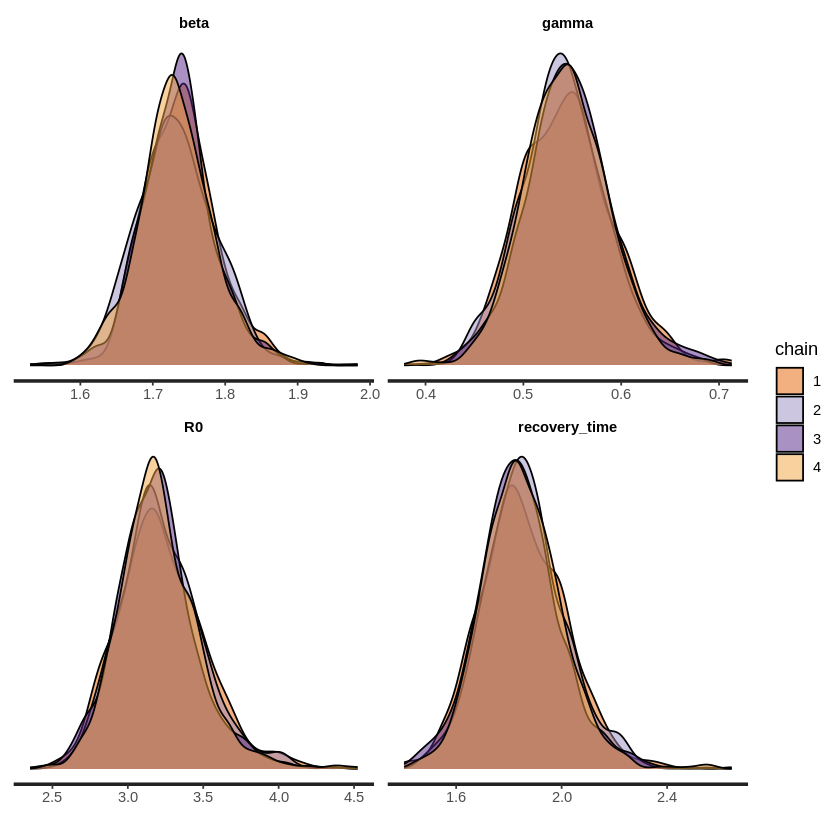

In [14]:
stan_dens(model_fit, pars = pars, separate_chains = TRUE)

In [15]:
print(model_fit, pars = pars)

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta          1.73    0.00 0.05 1.64 1.70 1.73 1.77  1.85  2529    1
gamma         0.54    0.00 0.05 0.46 0.51 0.54 0.57  0.64  2454    1
R0            3.21    0.01 0.27 2.73 3.03 3.19 3.37  3.83  2516    1
recovery_time 1.85    0.00 0.15 1.56 1.75 1.84 1.95  2.18  2495    1

Samples were drawn using NUTS(diag_e) at Mon Nov 11 07:32:50 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


And extract and visualize the generated data.

In [17]:
posterior_samples <- rstan::extract(model_fit)

In [18]:
sampled_indices <- sample(1:4000, 200)
sampled_data <- posterior_samples$pred_cases[sampled_indices, ]

First, by drawing samples from the posterior:

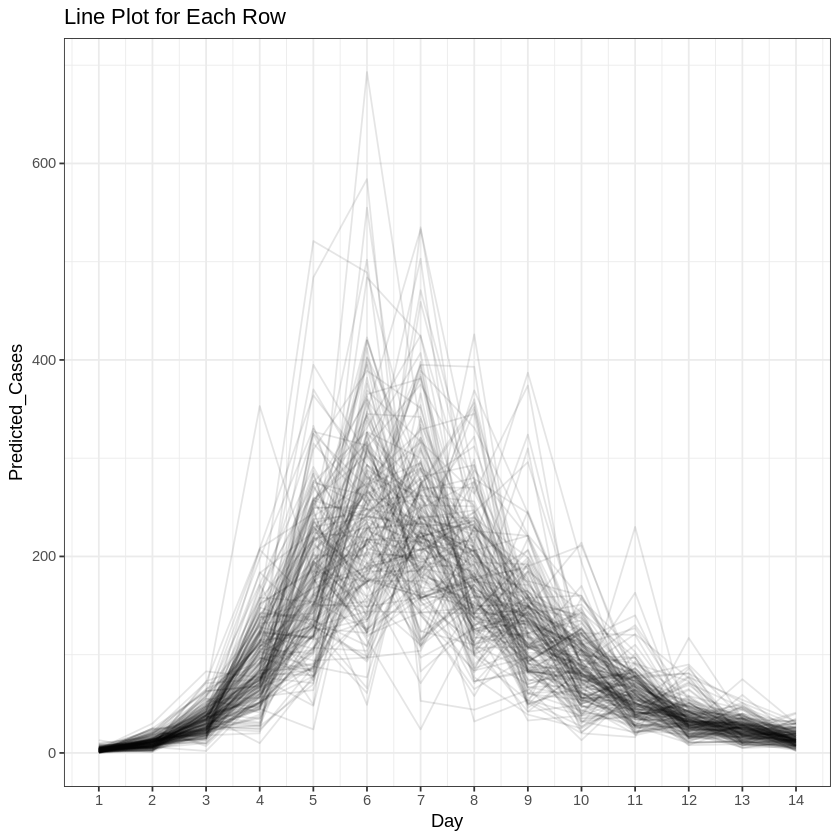

In [27]:
# Convert df from matrix to data.frame
df <- as.data.frame(sampled_data)

# Remove the "V" prefix from the column names and convert them to numeric
colnames(df) <- sub("^V", "", colnames(df))  # Remove 'V' from column names
colnames(df) <- as.numeric(colnames(df))  # Convert column names to numeric values

# Reshape the data from wide to long format
df_long <- df %>%
  mutate(Row = row_number()) %>%
  pivot_longer(cols = -Row, names_to = "Day", values_to = "Predicted_Cases") %>%
  mutate(Day = as.numeric(Day))  # Ensure TimePoint is numeric

# Create the ggplot with alpha for transparency
ggplot(df_long, aes(x = Day, y = Predicted_Cases, group = Row)) +
  geom_line(alpha = 0.1) +
  labs(x = "Day", y = "Predicted_Cases", title = "Line Plot for Each Row") +
  scale_x_continuous(breaks = seq(min(df_long$Day), max(df_long$Day), by = 1))

Below, we shade a 90% highest density interval (HDI) and plot a median line.

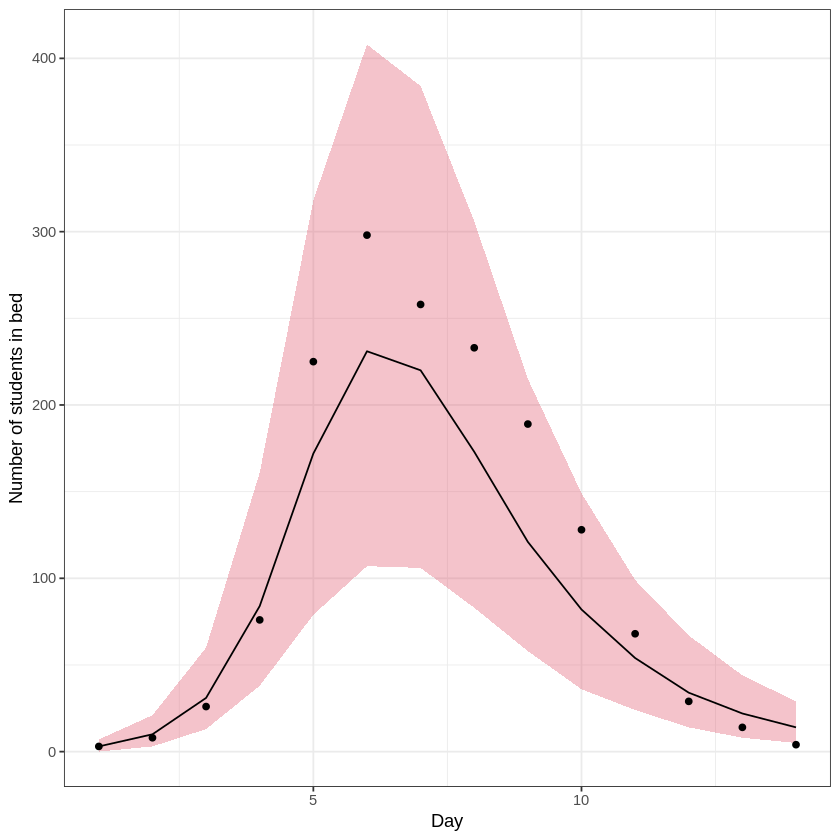

In [33]:
smr_pred <- cbind(as.data.frame(summary(
  fit_sir_negbin, pars = "pred_cases", probs = c(0.05, 0.5, 0.95))$summary), t, cases)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = 2, alpha = 0.35) +
  geom_line(mapping = aes(x = t, y = X50.), color = 'black') +
  geom_point(mapping = aes(y = cases)) +
  labs(x = "Day", y = "Number of students in bed")

And below, we focus on the expected number of new cases rather than total number of cases.

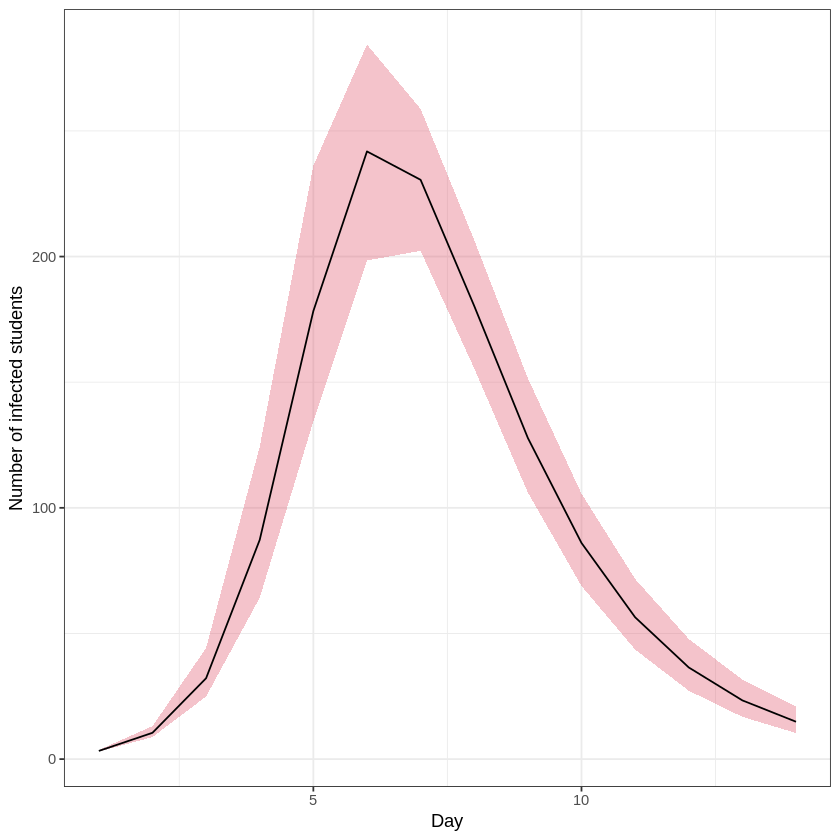

In [34]:
params <- lapply(t, function(i){sprintf("y[%s,2]", i)}) #number of infected for each day
smr_y <- as.data.frame(summary(fit_sir_negbin,
                               pars = params, probs = c(0.05, 0.5, 0.95))$summary)
colnames(smr_y) <- make.names(colnames(smr_y)) # to remove % in the col names

ggplot(smr_y, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = 2, alpha = 0.35) +
  geom_line(mapping = aes(x = t, y = X50.), color = "black") +
  labs(x = "Day", y = "Number of infected students")

And that's it for the ODE articles, but future content will likely include the solving of partial differential equations (PDEs), particularly with the use of physics-informed neural networks (PINNs).

# References

- Grinsztajn, L., Semenova, E., Margossian, C. C., & Riou, J. Bayesian workflow for disease transmission modeling in Stan. Stan User Docs. https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#3_scaling_up_ode-based_models

- (2016, October 27). Estimating Transmission by Fitting Mechanistic Models in Stan. Joseph Mihaljevic Blog. https://jrmihalj.github.io/estimating-transmission-by-fitting-mechanistic-models-in-Stan/

- Google Research (n.d.). Modeling and Control of a Campus COVID-19 Outbreak. https://colab.research.google.com/drive/1ddb_0swsq9MRKyHrzflCzeF8Tqqmp24H#scrollTo=eAbATGsb5fwf

- (2020, July 27). Upgrading to the new ODE interface. Stan User Docs. https://mc-stan.org/users/documentation/case-studies/convert_odes.html

- Handel, A. (2021). Infectious Disease Epidemiology - A Model Based Approach. https://andreashandel.github.io/IDEMAbook/